In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

import os
import logging
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from notebooks import utils, ts_plotter

logging.basicConfig(format='%(asctime)s | %(name)s | %(message)s',
    level=logging.INFO, datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger('INTM')

In [3]:
data = pd.read_csv('/home/alex/Projects/earthquake-prediction/data/train.csv')
#data.set_index('segment_id', inplace=True)
data.fillna(method='bfill', inplace=True)
data.fillna(value=0, inplace=True)
data.head()

,segment_id,target,all_centr_avg,all_bw_avg,all_contr_avg,all_flat_avg,all_rlf_avg,all_zrate_avg,all_mfcc0_avg,all_mfcc1_avg,...,last1000_mfcc10_avg,last1000_mfcc11_avg,last1000_mfcc12_avg,last1000_mfcc13_avg,last1000_mfcc14_avg,last1000_mfcc15_avg,last1000_mfcc16_avg,last1000_mfcc17_avg,last1000_mfcc18_avg,last1000_mfcc19_avg
0,0,1.4308,3722.59122,3103.66044,25.51002,0.07340,7650.68093,0.07384,335.47955,29.93017,...,5.24199,4.52290,3.32037,3.06895,5.12868,9.34556,5.77004,2.68648,2.79190,4.34597
1,1,1.3915,3689.16105,3077.67029,25.11218,0.07440,7546.02809,0.07986,337.90257,31.48825,...,5.87698,5.07276,3.36021,3.23783,5.20496,9.25102,5.74487,2.87633,2.56180,3.63488
2,2,1.3532,3564.80205,3047.29727,25.45482,0.06884,7372.62334,0.07945,343.82938,36.75975,...,6.07110,4.88589,3.44933,3.57342,4.95428,10.03900,5.73357,3.20955,2.58791,3.83244
3,3,1.3138,3645.72734,3081.05180,25.92773,0.07068,7515.30837,0.07453,339.50314,33.66972,...,5.72452,5.53723,2.99253,3.22109,4.63031,8.73286,5.49859,3.06452,2.63206,4.15588
4,4,1.2744,3634.14436,3072.84835,25.49402,0.07009,7466.14211,0.07250,339.98561,34.58752,...,5.01630,4.92190,2.98276,3.05855,5.07589,8.71375,5.42013,3.00922,2.75107,3.63889


In [5]:
features = [c for c in data.columns if c not in ['segment_id', 'target']]

In [6]:
best_features = utils.print_features_imp(data[features], data['target'], logger, permutation=True, min_imp=0.03)
best_features

2019-05-30 00:27:53 | INTM |   Imp | Feature
2019-05-30 00:27:56 | INTM |   10% | all_mfcc0_avg
2019-05-30 00:27:56 | INTM |   10% | last1000_mfcc15_avg
2019-05-30 00:27:56 | INTM |    9% | last1000_mfcc0_avg
2019-05-30 00:27:56 | INTM |    9% | all_mfcc5_avg
2019-05-30 00:27:56 | INTM |    8% | last1000_mfcc2_avg
2019-05-30 00:27:56 | INTM |    7% | all_mfcc2_avg
2019-05-30 00:27:56 | INTM |    7% | all_mfcc15_avg
2019-05-30 00:27:56 | INTM |    6% | all_centr_avg
2019-05-30 00:27:56 | INTM |    5% | last1000_mfcc5_avg
2019-05-30 00:27:56 | INTM |    5% | all_mfcc4_avg
2019-05-30 00:27:56 | INTM |    5% | last1000_centr_avg
2019-05-30 00:27:56 | INTM |    4% | last1000_mfcc4_avg
2019-05-30 00:27:56 | INTM |    3% | all_zrate_avg
2019-05-30 00:27:56 | INTM |    3% | last1000_zrate_avg
2019-05-30 00:27:56 | INTM |    2% | last1000_flat_avg
2019-05-30 00:27:56 | INTM |    2% | all_flat_avg
2019-05-30 00:27:56 | INTM |    2% | last1000_mfcc8_avg
2019-05-30 00:27:56 | INTM |    2% | all_mf

['all_mfcc0_avg',
 'last1000_mfcc15_avg',
 'last1000_mfcc0_avg',
 'all_mfcc5_avg',
 'last1000_mfcc2_avg',
 'all_mfcc2_avg',
 'all_mfcc15_avg',
 'all_centr_avg',
 'last1000_mfcc5_avg',
 'all_mfcc4_avg',
 'last1000_centr_avg',
 'last1000_mfcc4_avg',
 'all_zrate_avg']

In [6]:
utils.tune_random_forest(data[best_features], data['target'], logger, max_features=range(1,5), 
    n_estimators=[100], n_splits=5)

2019-05-29 21:20:27 | INTM |   n_est | n_feats | n_leafs |     MSE |     MAE
2019-05-29 21:20:29 | INTM |     100 |       1 |       1 |    0.00 |    2.17 | 
2019-05-29 21:20:29 | INTM | scores: [2.08103267 2.2515981  2.59851937 1.39408564 2.53727488]
2019-05-29 21:20:33 | INTM |     100 |       2 |       1 |    0.00 |    2.18 | 
2019-05-29 21:20:33 | INTM | scores: [2.08749766 2.26683214 2.61470389 1.40775875 2.54793834]
2019-05-29 21:20:37 | INTM |     100 |       3 |       1 |    0.00 |    2.20 | 
2019-05-29 21:20:37 | INTM | scores: [2.08457767 2.277237   2.64289276 1.40737971 2.5657583 ]
2019-05-29 21:20:43 | INTM |     100 |       4 |       1 |    0.00 |    2.20 | 
2019-05-29 21:20:43 | INTM | scores: [2.08612437 2.29062952 2.62185541 1.42885595 2.56454914]


In [8]:
train = data.query('segment_id < 3000')
test = data.query('segment_id >= 3000')
model = CatBoostRegressor(random_seed=0, depth=4, random_strength=0.5, learning_rate=0.03, 
    loss_function='RMSE', verbose=False)
utils.catboost_best_iter(model, logger, train[best_features], train['target'], test[best_features], test['target'])

2019-05-29 18:03:29 | INTM | best iteration: 84


In [18]:
utils.tune_catboost(data[best_features], data['target'], n_splits=5,
    iterations=[80,85,90,100,120], tree_depth=[4], learning_rate=[0.03], random_strength=[0.5])

2019-05-29 22:20:33 | INTM | iter | depth | rand | rate |   L2 | temp |    LF |     MAE
2019-05-29 22:20:35 | INTM |   80 |     4 |  0.5 | 0.03 |  3.0 |  1.0 |  RMSE |    2.12
2019-05-29 22:20:37 | INTM |   85 |     4 |  0.5 | 0.03 |  3.0 |  1.0 |  RMSE |    2.13
2019-05-29 22:20:40 | INTM |   90 |     4 |  0.5 | 0.03 |  3.0 |  1.0 |  RMSE |    2.13
2019-05-29 22:20:43 | INTM |  100 |     4 |  0.5 | 0.03 |  3.0 |  1.0 |  RMSE |    2.13
2019-05-29 22:20:47 | INTM |  120 |     4 |  0.5 | 0.03 |  3.0 |  1.0 |  RMSE |    2.14


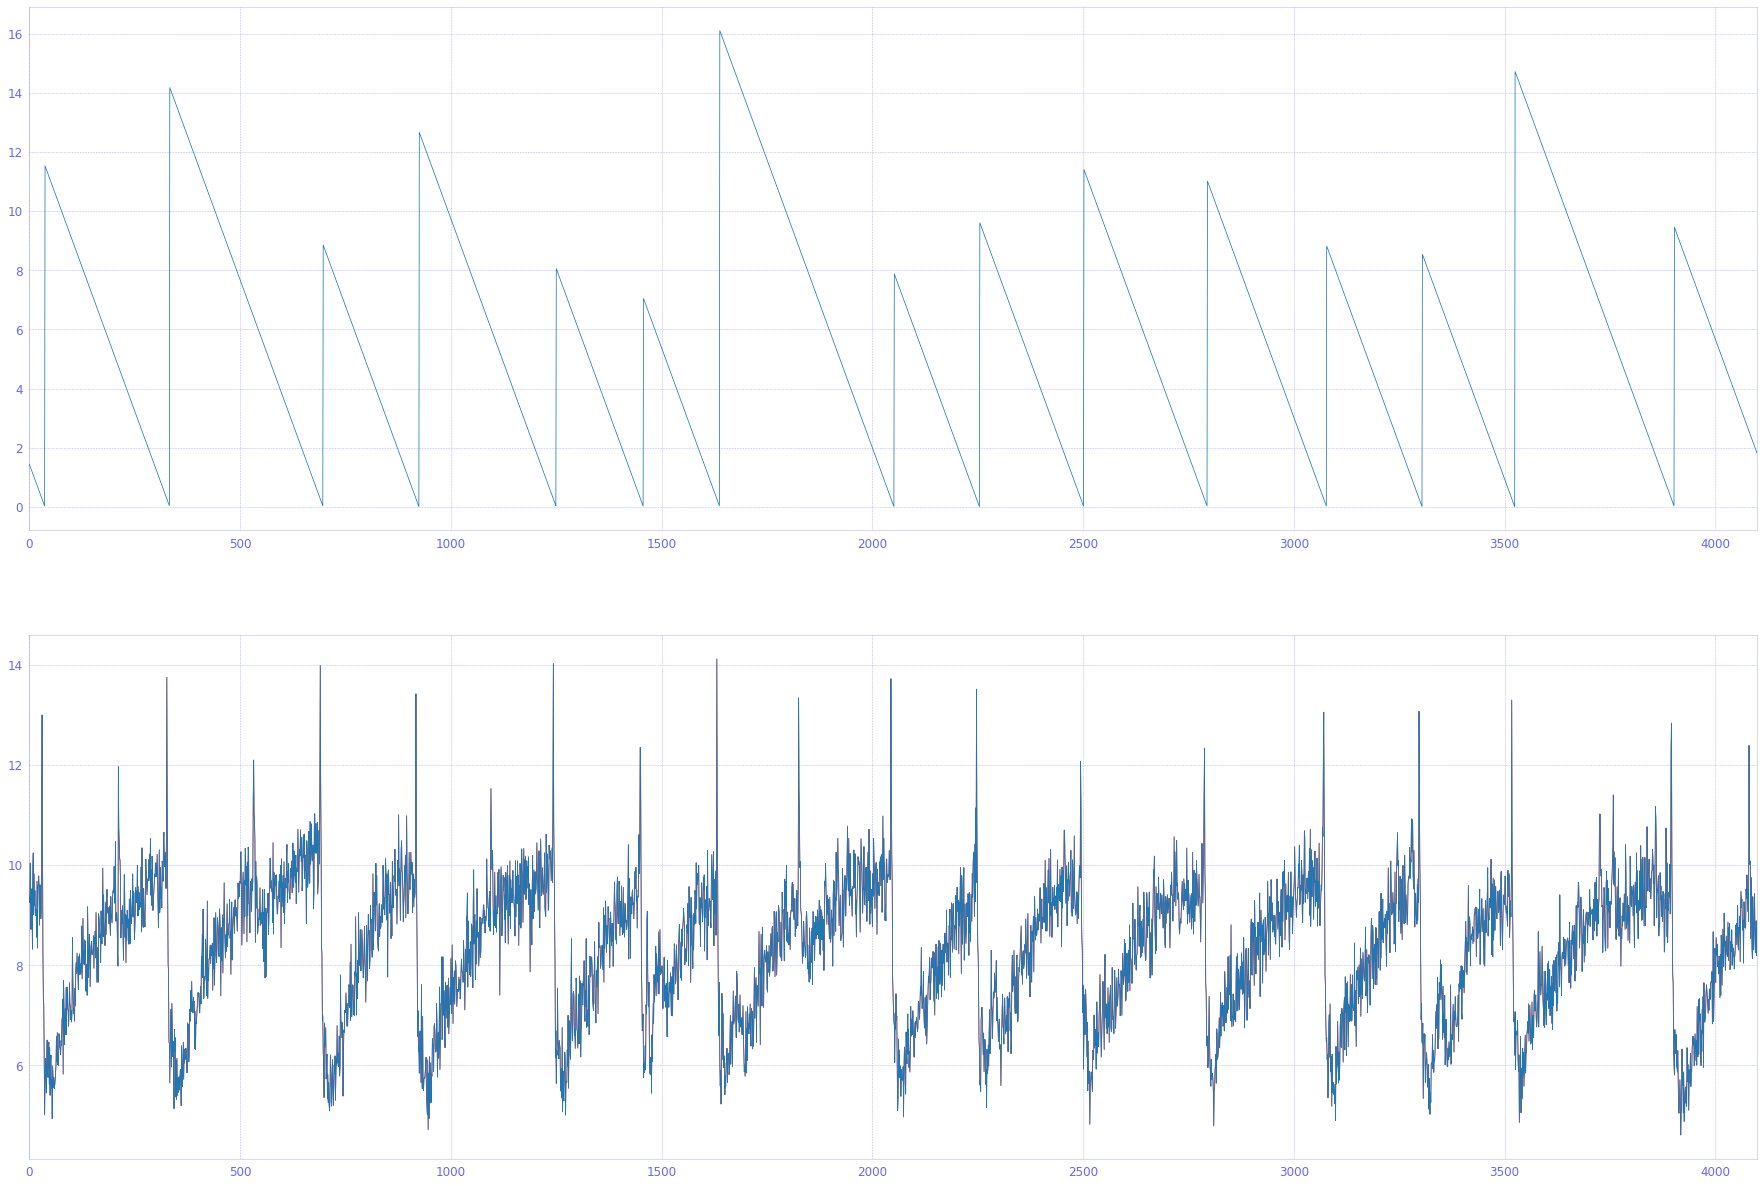

In [120]:
plotter = ts_plotter.TimeSeriesPlot(fig_size=(30, 20), n_rows=2, n_cols=1, type='line', show=False)
fig=plotter.plot(data, y_vars=['target'], x_var='segment_id', xlim=[0, 4100], id=1, close_fig=False)
plotter.plot(data, y_vars=['all_mfcc15_avg', 'last1000_mfcc15_avg'], x_var='segment_id', xlim=[0, 4100], id=2, fig=fig)

In [58]:
train = data.query('segment_id < 2500')
test = data.query('segment_id >= 2500')
model = CatBoostRegressor(verbose=False)
#model = RandomForestRegressor(n_estimators=100)
model.fit(train[best_features], train['target'])
res=pd.DataFrame()
res['segment_id'] = test['segment_id']
res['y']=test['target']
res['y_hat']=model.predict(test[best_features])

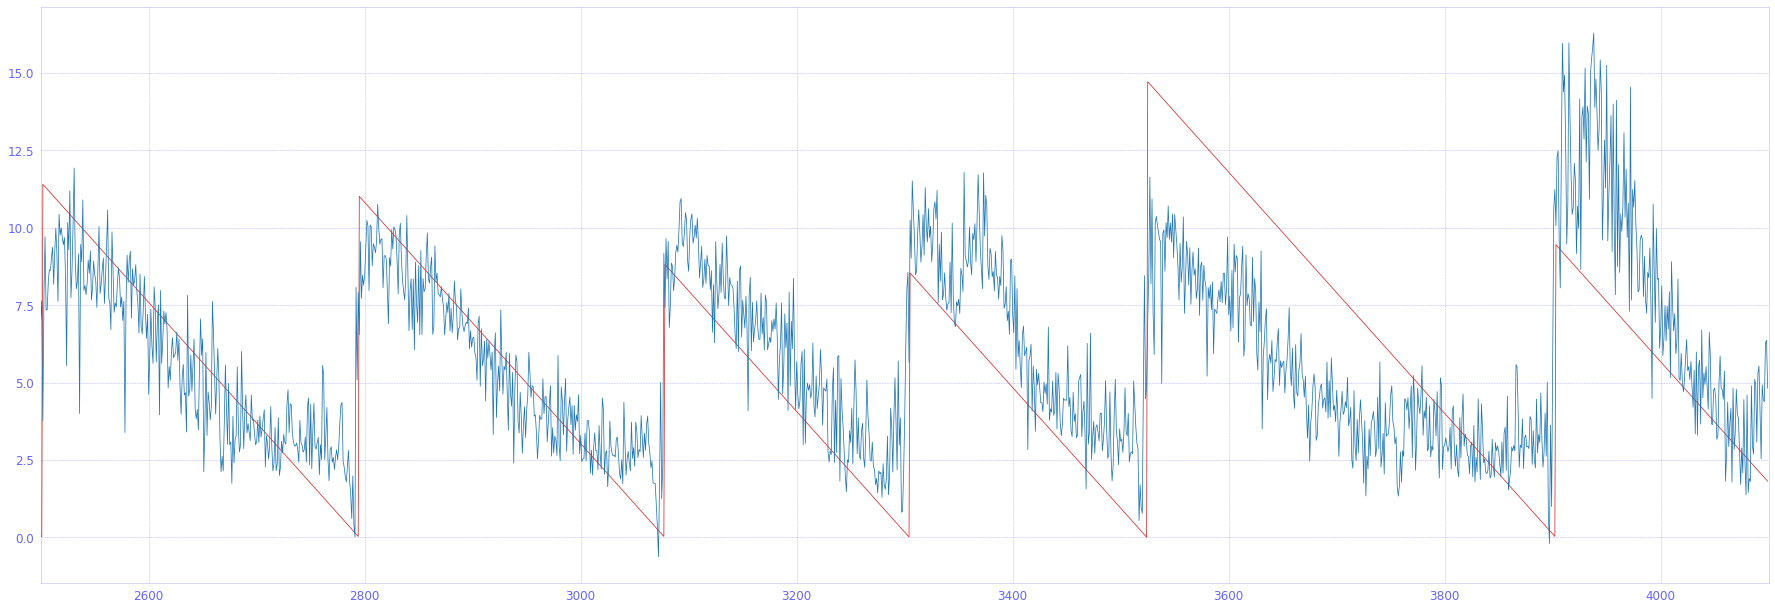

In [59]:
plotter = ts_plotter.TimeSeriesPlot(fig_size=(30, 10), n_rows=1, n_cols=1, type='line', show=False)
plotter.plot(res, y_vars=['y', 'y_hat'], x_var='segment_id', xlim=[2500, 4100])

In [60]:
np.mean(np.abs(res['y'].values - res['y_hat'].values))

1.972124322972541

In [18]:
d=pd.read_hdf('/home/alex/Projects/kaggle-eathquake/data/train_int16float32.hdf', start=0, stop=6e6)
x = d['acoustic_data'].values.astype('float32')

FileNotFoundError: File /home/alex/Projects/kaggle-eathquake/data/train_int16float32.hdf does not exist

In [107]:
mfcc = librosa.feature.mfcc(y=x)

In [33]:
spec_c = librosa.feature.spectral_centroid(y=x)
spec_bw = librosa.feature.spectral_bandwidth(y=x)

In [47]:
S = np.abs(librosa.stft(x))
contrast = librosa.feature.spectral_contrast(S=S)

In [30]:
flatness = librosa.feature.spectral_flatness(y=x)

In [52]:
rolloff = librosa.feature.spectral_rolloff(y=x)

In [53]:
rate = librosa.feature.zero_crossing_rate(y)

In [110]:
tempo, beats = librosa.beat.beat_track(y=x)

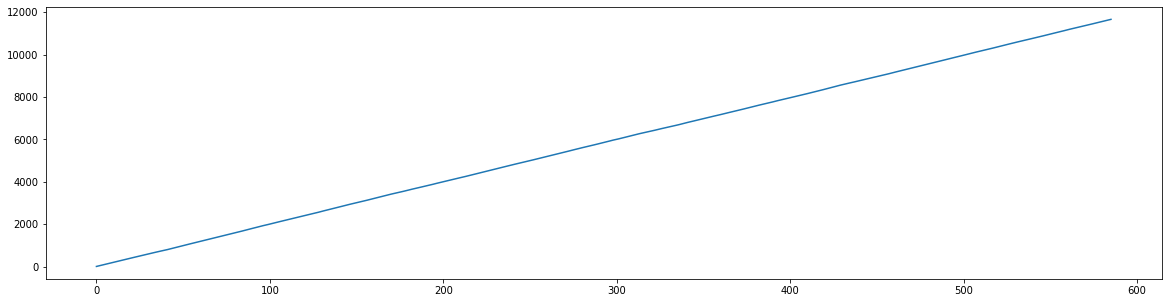

In [113]:
plt.figure(figsize=(20,5))
plt.plot(beats)
plt.show()

In [57]:
len(mfcc)

20

In [21]:
keys=store.keys()

In [22]:
keys[0]

'/seg_00030f'

In [25]:
store.close()

In [19]:
t=['x', 'xx', 'xxx']
'_'.join([x for x in t])

'x_xx_xxx'